In [0]:
# dont ask me, and I won't clean it..
import numpy as np
import glob
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
%tensorflow_version 1.x
from PIL import Image
from keras import layers
from keras.models import Model
from keras.models import load_model
from keras.utils.vis_utils import plot_model  #plotting the model structure
from keras import callbacks
from datetime import datetime
import os
import cv2
import string
import numpy as np


from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import warnings
warnings.filterwarnings('ignore')
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint


from keras import layers        # functional 
from keras.models import Model
from keras.models import load_model
from keras import callbacks
import cv2
import string
import numpy as np
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras

In [0]:
! wget "https://ndownloader.figshare.com/files/22134801" -O railway_captcha4.tar.gz

--2020-03-30 08:36:10--  https://ndownloader.figshare.com/files/22134801
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 34.249.41.128, 18.203.214.185, 54.229.26.46, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|34.249.41.128|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/22134801/railway_captcha4.tar.gz [following]
--2020-03-30 08:36:11--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/22134801/railway_captcha4.tar.gz
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.24.10
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.24.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 266124115 (254M) [application/gzip]
Saving to: ‘railway_captcha4.tar.gz’

railway_captcha4.ta 100%[===================>] 253.79M  11.9MB/s    in 24s     

2020-03-30 08:36:36 (10.7 MB/s) - ‘railway_captcha4

In [0]:
!tar -xvf railway_captcha4.tar.gz > /dev/null
! echo "Untaring... done..."

Untaring... done...


In [0]:
png_files = glob.glob('railway_captcha4/*.jpg')
print("Total # of files => ",len(png_files))
png_files[0]

Total # of files =>  100000


'railway_captcha4/0293_1072.jpg'

In [0]:
symbols = "ABCDEFGHJKLMNPQRSTUVWXYZ" + '0123456789' # These are all symbols the captchas will have
num_symbols = len(symbols)
img = np.array(Image.open(png_files[0]))
shape_ = img.shape
print(shape_, num_symbols)

(60, 200, 3) 34


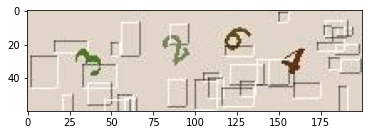

In [0]:
img_path = png_files[1]
img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
plt.imshow(img)
plt.show()

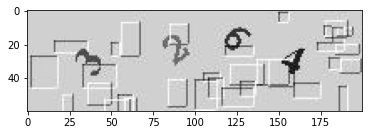

(60, 200)


In [0]:
img_path = png_files[1]
img_gray = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
plt.imshow(img_gray,cmap='gray')
plt.show()
print(img_gray.shape)

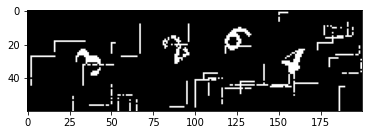

(60, 200)


In [0]:
# perform OTSU's thresholding
ret,thresh = cv2.threshold(img_gray,127,255,cv2.THRESH_BINARY_INV)
plt.imshow(thresh,cmap='gray')
plt.show()
print(thresh.shape)

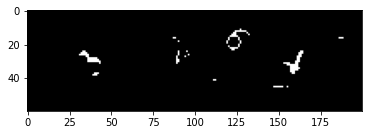

In [0]:
kernel = np.ones((2,2),np.uint8)
#dialate = cv2.dilate(thresh,kernel,iterations = 1)
erosion = cv2.erode(thresh,kernel,iterations = 1)
plt.imshow(erosion,cmap='gray')
plt.show()

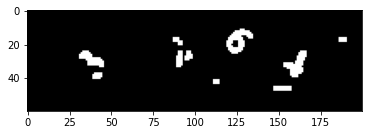

In [0]:
#kernel = np.ones((2,2),np.uint8)
dialate = cv2.dilate(erosion,kernel,iterations = 2)
#erosion = cv2.erode(thresh,kernel,iterations = 1)
plt.imshow(dialate,cmap='gray')
plt.show()

In [0]:
def create_model():
  in_ = Input(shape=img_shape)
  out = in_
  out = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Dropout(0.3)(out)
  out = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Dropout(0.3)(out)
  out = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(out)
  out = Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Dropout(0.3)(out)
  out = Conv2D(filters=256, kernel_size=(3, 3), activation='relu')(out)
  out = BatchNormalization()(out)
  out = MaxPooling2D(pool_size=(2, 2))(out)
  out = Flatten()(out)
  out = Dropout(0.3)(out)
  out = [Dense(34, name='digit1', activation='softmax')(out),\
      Dense(34, name='digit2', activation='softmax')(out),\
      Dense(34, name='digit3', activation='softmax')(out),\
      Dense(34, name='digit4', activation='softmax')(out)]
      #Dense(34, name='digit5', activation='softmax')(out)]
  model = Model(inputs=in_, outputs=out)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [0]:
from tqdm import tqdm
kernel = np.ones((2,2),np.uint8)
letters_in_captcha = 4
def preprocess_data():
  n_samples = len(os.listdir('railway_captcha4/'))
  X = np.zeros((n_samples, 200, 60, 1)) #1070*50*200
  print(num_symbols,n_samples)
  y = np.zeros((letters_in_captcha, n_samples, num_symbols)) #5*1070*36
  for i, pic in tqdm(enumerate(os.listdir('railway_captcha4/'))):
    # Read image as grayscale
    img = cv2.imread(os.path.join('railway_captcha4/', pic), cv2.IMREAD_GRAYSCALE)
    #img = cv2.resize(img, (200,60), interpolation = cv2.INTER_AREA)
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    # firstly perform erosion
    erosion = cv2.erode(thresh,kernel,iterations = 1)
    # perform dialation
    dialate = cv2.dilate(erosion,kernel,iterations = 1)
    img = dialate.copy()
    pic_target = pic.split('_')[0]
    # plt.imshow(img,cmap='gray')
    # plt.show()
    # break
    # if len(pic_target) < 5:
    # Scale and reshape image
    #print("?")
    img = img / 255.0
    #plt.imshow(img,cmap='gray')
    img = np.reshape(img, (200, 60, 1))
    # Define targets and code them using OneHotEncoding
    targs = np.zeros((letters_in_captcha, num_symbols))
    #print("num symbols = ",num_symbols)
    for j, l in enumerate(pic_target):
      ind = symbols.find(l)
      targs[j, ind] = 1
    X[i] = img
    y[:, i] = targs
    
  # Return final data
  return X, y

X, y = preprocess_data()

0it [00:00, ?it/s]

34 100000


100000it [00:21, 4753.69it/s]


In [0]:
#print(X[0])
print(X[0].shape)
#print(y[0])
print(y[0].shape)

(200, 60, 1)
(100000, 34)


In [0]:
X_train, y_train = X[:90000], y[:, :90000]
X_test, y_test = X[90000:], y[:, 90000:]

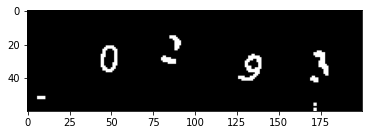

(200, 60, 1)


In [0]:
plt.imshow(X_train[0].reshape((60,200)),cmap='gray')
plt.show()
print(X_train[0].shape)

In [0]:
print(X_train.shape)

(90000, 200, 60, 1)


In [0]:
img_shape = (200, 60, 1)
model=create_model();
model.summary();













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 60, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 200, 60, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 198, 58, 32)  9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 198, 58, 32)  128      

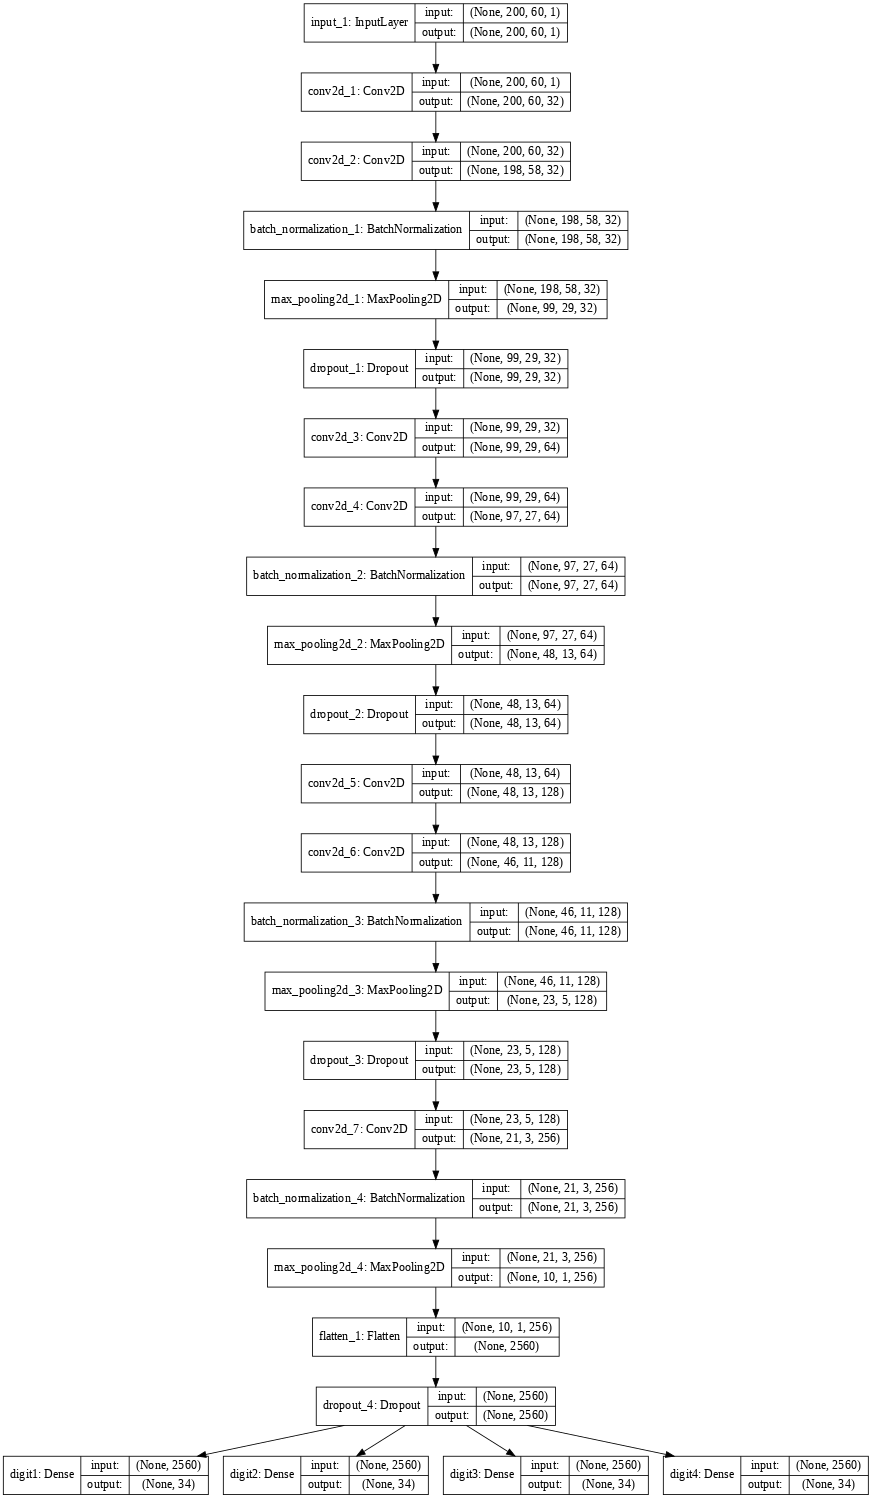

In [0]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True,dpi=60)

In [0]:
# for storing logs into tensorboard
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2],y_train[3]], batch_size=32, epochs=30,verbose=1, validation_split=0.2,callbacks=[tensorboard_callback])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 72000 samples, validate on 18000 samples
Epoch 1/30
72000/72000 [==============================] - 120s 2ms/step - loss: 11.2500 - digit1_loss: 2.8281 - digit2_loss: 2.8065 - digit3_loss: 2.8107 - digit4_loss: 2.8047 - digit1_acc: 0.1215 - digit2_acc: 0.1217 - digit3_acc: 0.1240 - digit4_acc: 0.1207 - val_loss: 10.1099 - val_digit1_loss: 2.5341 - val_digit2_loss: 2.5216 - val_digit3_loss: 2.5321 - val_digit4_loss: 2.5221 - val_digit1_acc: 0.1577 - val_digit2_acc: 0.1676 - val_digit3_acc: 0.1624 - val_digit4_acc: 0.1628
Epoch 2/30
72000/72000 [==============================] - 109s 2ms/step - loss: 9.6012 - digit1_loss: 2.3933 - digit2_loss: 2.3978 - digit3_loss: 2.4075 - digit4_loss: 2.4026 - digit1_acc: 0.2095 - digit2_acc: 0.2093 - digit3_acc: 0.2073 - digit4_acc: 0.2061 - val_loss: 11.2568 - val_digit1_loss: 2.5864 - val_digit2_loss: 2.8292 - val_digit3_loss: 2.7711 - val_digit4_

In [0]:
plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['acc']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Accuracy ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper left')
plt.show()

plt.figure(figsize=(12,7))
legend_acc = []
for item in hist.history.keys():
  if item.split('_')[-1:] == ['loss']:
    #print("Accuracy = ",item)
    legend_acc.append(item)
    plt.plot(hist.history[item])
plt.ylabel('Loss ->')
plt.xlabel('Epoch ->')
plt.legend(legend_acc, loc='upper right')
plt.show()

In [0]:
# Define function to predict captcha
def predict(filepath):
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
    # firstly perform erosion
    erosion = cv2.erode(thresh,kernel,iterations = 1)
    # perform dialation
    dialate = cv2.dilate(erosion,kernel,iterations = 1)
    img = dialate.copy()
    if img is not None:
        img = img / 255.0
    else:
        print("Not detected");
    #res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    new_im = img.reshape((img.shape[1],img.shape[0]))
    res = np.array(model.predict(new_im[np.newaxis,:,:,np.newaxis]))
    #print(res)
    ans = np.reshape(res, (3, 34))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

In [0]:
total_img = 36
num_pr = 6 # number per row

counter = 1
plt.figure(figsize=(30,15))
plt.axis('off')
for item in png_files[:total_img]:
  image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
  pred = predict(item)
  #print(pred)
  image_bckup = image.copy()
  plt.subplot(num_pr, num_pr, counter)
  #print("item => ",item)
  #print("item => ",str(item.split('_')[1]).split('/')[1])
  if str(item.split('_')[1]).split('/')[1] == str(pred):
    plt.title("Prediction = {}".format(pred),fontsize=20).set_color('green')
  else:
    plt.title("Prediction = {}".format(pred),fontsize=20).set_color('red')
  plt.axis('off')
  plt.imshow(image_bckup, cmap=plt.get_cmap('gray'))
  counter += 1
  #break
plt.show()

In [0]:
score= model.evaluate(X_test,[y_test[0], y_test[1], y_test[2],y_test[3]],verbose=1)
print('Test Loss and accuracy:', score)
model.evaluate(X_test, [y_test[0], y_test[1], y_test[2],y_test[3]])

In [0]:
num_viz = 10
for item in png_files[:num_viz]:
  # image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
  # image_bckup = image.copy()
  # image = image[np.newaxis,:, :, np.newaxis]/255.0
  image = cv2.imread(item, cv2.IMREAD_UNCHANGED)
  pred = predict(item)
  print(pred)

In [0]:
# download the model in computer for later use

model.save('railway_captcha_4_imop.h5')
# download the model from colab
from google.colab import files
files.download('railway_captcha_4_imop.h5')

In [0]:
## incase you have lost the model then...

# model.load_weights('railway_captcha_4_imop.h5')

In [0]:
import numpy as np
import random
import math
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.gridspec as gridspec
from tensorflow.keras.preprocessing.image import ImageDataGenerator

successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
# horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
# human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
# img_path = random.choice(horse_img_files + human_img_files)
img_path = png_files[0]



img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (200,60), interpolation = cv2.INTER_AREA)
ret,thresh = cv2.threshold(img,127,255,cv2.THRESH_BINARY_INV)
# firstly perform erosion
erosion = cv2.erode(thresh,kernel,iterations = 1)
# perform dialation
dialate = cv2.dilate(erosion,kernel,iterations = 1)
img = dialate.copy()

img = img / 255.0
#plt.imshow(img,cmap='gray')
img = np.reshape(img, (200, 60, 1))


x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)



plt.imshow(x.reshape((60,200)), cmap='viridis')

# img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# #img_res = cv2.resize(img, (300, 300), interpolation = cv2.INTER_AREA) 
# #img = load_img(img_path, target_size=(50, 200))  # this is a PIL image
# x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
# x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
# x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    size2 = feature_map.shape[2]
    # We will tile our images in this matrix
    width = 20*20
    height = 8*20
    plt.figure(figsize=(width,height))
    #fig.subplots_adjust(hspace=0.04, wspace=0.04)
    #display_grid = np.zeros((size, size * n_features))
    count = 1
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      #ax = fig.add_subplot(int(n_features/4), int(n_features/4), count)
      
      plt.subplot(int(n_features/4), int(n_features/4), count)
      plt.subplots_adjust(hspace = .0001)
      plt.axis("off")
      #ax1.set_aspect('equal')
      #x.reshape((60,200))
      plt.imshow(x.reshape((x.shape[1],x.shape[0])), cmap='viridis')
      count += 1
  #print(x.shape)
  #break

#plt.show()
print(png_files[0])